In [1]:
%pip install qiskit numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
import numpy as np

We are implementing a multi-controlled U gate using only single qubit gates and CNOTs. To do so, we will implement this gate using the temporary logical and gate introduced by Gidney. This gate requires that the ancilla qubits used must start in the ``T state'', so we implement a state preparation circuit below.

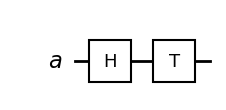

In [287]:
# State Preparation Circuit converts 0 to T state
ancilla_register = AncillaRegister(size=1, name="a")
state_prep_circuit = QuantumCircuit(ancilla_register, name = "State Preparation")
state_prep_circuit.h(ancilla_register)
state_prep_circuit.t(ancilla_register)
state_prep_circuit.draw(output="mpl", style="bw")

In [288]:
Prep = state_prep_circuit.to_gate()

This is the temporary logical and circuit. As written, we return the ancilla qubit back to 0, although for less computational cost, we could return it back to the T state as well

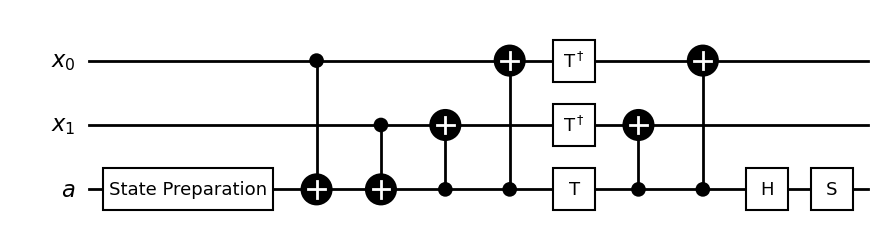

In [305]:
# Temporary Logical And Circuit
# Takes two qubits A and B and returns A, B, and (A AND B)
#The implementation is from Gidney's paper, ``Halving the Cost of Quantum Addition''
quantum_register = QuantumRegister(size=2,name="x")
ancilla_register = AncillaRegister(size=1,name="a")

and_circuit = QuantumCircuit(quantum_register,ancilla_register, name = "Temp_And")
and_circuit.compose(Prep,qubits = ancilla_register,inplace=True)
and_circuit.cx(quantum_register[0],ancilla_register)
and_circuit.cx(quantum_register[1],ancilla_register)
and_circuit.cx(ancilla_register,quantum_register[1])
and_circuit.cx(ancilla_register,quantum_register[0])
and_circuit.tdg(quantum_register[1])
and_circuit.tdg(quantum_register[0])
and_circuit.t(ancilla_register)
and_circuit.cx(ancilla_register,quantum_register[1])
and_circuit.cx(ancilla_register,quantum_register[0])
and_circuit.h(ancilla_register)
and_circuit.s(ancilla_register)
and_circuit.draw(output="mpl", style="bw")

In [291]:
And_Gate = and_circuit.to_gate()

As our implementation is, at its heart, an inductive process, we need to treat the implementation of a controlled U-gate separately, which we do below. However, we treat the phase shift separately.

In [307]:
#We implement the single controlled U gate separately, as we will be controlling on the AND of our control qubits
#We only implement the case when U has determinant one, i.e., it has no phase shift.
def CU_Gate(theta, phi,lam):
    quantum_register = QuantumRegister(size=2,name="x")
    cu_circuit = QuantumCircuit(quantum_register, name="CU")
    cu_circuit.rz((lam-phi/2)/2,quantum_register[1])
    cu_circuit.cx(quantum_register[0],quantum_register[1])
    cu_circuit.rz(-(lam+phi/2)/2,quantum_register[1])
    cu_circuit.ry(-theta/4,quantum_register[1])
    cu_circuit.cx(quantum_register[0],quantum_register[1])
    cu_circuit.ry(theta/4,quantum_register[1])
    cu_circuit.rz(phi/2,quantum_register[1])
    return cu_circuit
    

In [313]:
#The phase shift I haven't managed to implement yet.
def CnU_Gate(n: int,theta,phi,lam,alpha):
    if phi+lam != 0:
        return "Please enter a U gate with phase shift handled separately"
    else:
        quantum_register = QuantumRegister(size=int(n+1),name="x")
        ancilla_register = AncillaRegister(size=int(n-1),name="a")
        cnu_circuit = QuantumCircuit(quantum_register,ancilla_register, name="CnU")
        #This implements each of the temporary and pairwise
        #It also compares the values of each of the resulting values, until the final value is 1 only if every qubit is 1
        for i in range(1,n):
            cnu_circuit.compose(And_Gate,qubits=[2*i-1,2*i,-n+i],inplace=True)
        #This implements the controlled U gate
        cnu_circuit.compose(CU_Gate(theta,phi,lam),qubits=[2*n-1,0],inplace=True)
        #This undoes the temporary And values to gain the use of the ancillae again.
        for i in reversed(range(1,n)):
            cnu_circuit.compose(And_Gate.inverse(),qubits=[2*i-1,2*i,-n+i],inplace=True)
        return cnu_circuit.draw(output="mpl",style="bw")

What follows is an example circuit diagram with n=4

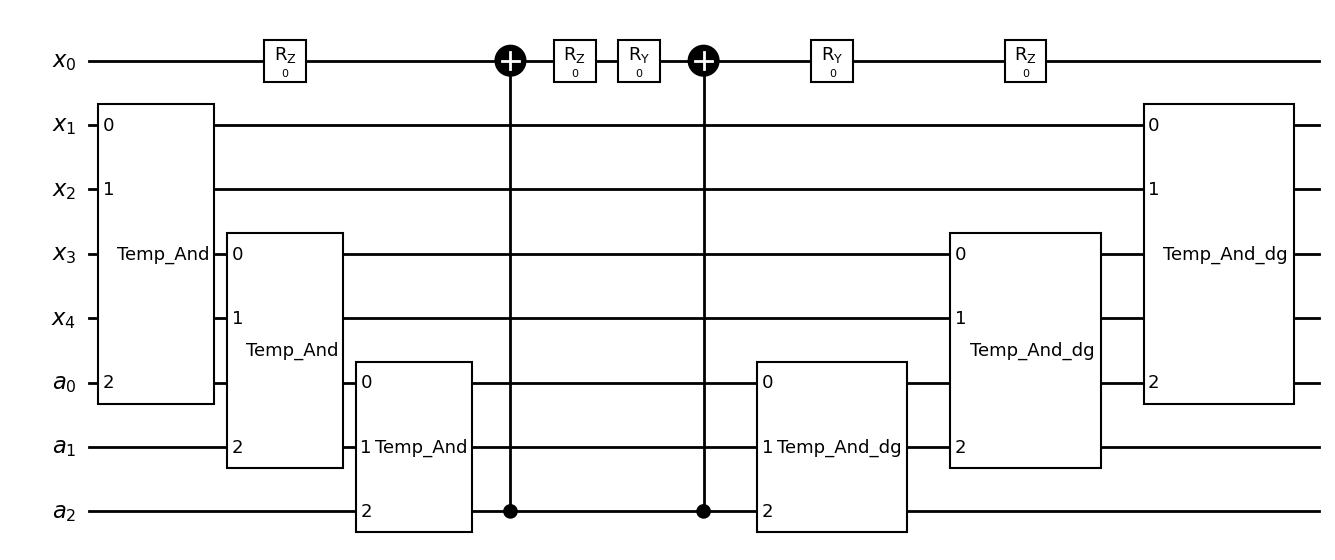

In [316]:
CnU_Gate(4,0,0,0,0)

Explanation of the construction:

This implementation is fairly straightforward. Given n qubits, $x_1,\cdots, x_n$, it compares the values of $x_i,x_{i+1}$ pairwise, all in parallel, and returning a result in an ancilla bit. It then compares the values of each of these ancilla bits, and so on, until every qubit has been compared in one go. This will take at most $\log_2 n$ steps. It then implements a single controlled U gate, controlled on the final ancilla, and then uncomputes each of the ancillas.

Analysis:

Gate depth: In this regard, I believe this implementation is rather successful. Without the phase shift, this has gate depth of O($\log_2(n)$), because many of the temporary and gates can be operated in parallel (although this can't be seen in the diagram as easily). However, to implement the phase shift, I expect this will lift the gate depth to O(n), unless there is a clean way to retain the phase shift while uncomputing the temporary and gates (which is possible, but I haven't had a chance to fully think about it yet).

Gate count: The gate count is linear in $n$, as the number of temporary and gates needed is linear in $n$.

Ancillas: This is one of the major shortcomings of this implementation, in that the ancillas needed grow linearly with $n$. The one possible saving grace of this is that there are fewer $T$-gates needed then one might need for the standard Toffoli gate implementation, and, if the analysis from Gidney's paper is still current (unclear to me at the moment), then there is some benefit to minimizing T-gates, even at the expense of more ancillas.

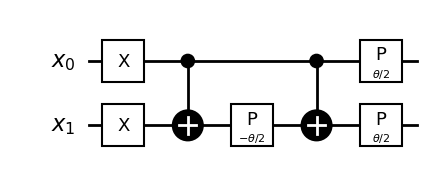

In [160]:
Theta = Parameter(r"$\theta$") # https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Parameter

quantum_register = QuantumRegister(2, "x")

quantum_circuit = QuantumCircuit(quantum_register)

quantum_circuit.x(quantum_register)
quantum_circuit.cx(quantum_register[0], quantum_register[1])
quantum_circuit.p(- Theta/2, quantum_register[1])
quantum_circuit.cx(quantum_register[0], quantum_register[1])
quantum_circuit.p(Theta/2, quantum_register[0])
quantum_circuit.p(Theta/2, quantum_register[1])

# assign value to the parameter, define a new circuit bc
bc = quantum_circuit.assign_parameters({Theta: np.pi})

quantum_circuit.draw(output="mpl", style="bw")

In [153]:
Statevector(bc).draw("Latex") (1,0) -> (1,0) -> (1,1) -> 

<IPython.core.display.Latex object>

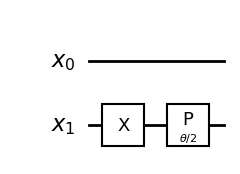

In [107]:
Theta = Parameter(r"$\theta$") # https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Parameter

quantum_register = QuantumRegister(2, "x")

quantum_circuit = QuantumCircuit(quantum_register)

quantum_circuit.x(quantum_register[1])
quantum_circuit.p(Theta / 2, quantum_register[1])

# assign value to the parameter, define a new circuit bc
bc = quantum_circuit.assign_parameters({Theta: np.pi / 2})

quantum_circuit.draw(output="mpl", style="bw")

In [108]:
Statevector(bc).draw("Latex")

<IPython.core.display.Latex object>

In [109]:
np.round(Operator(bc).data, 3)


array([[0.   +0.j   , 0.   +0.j   , 1.   +0.j   , 0.   +0.j   ],
       [0.   +0.j   , 0.   +0.j   , 0.   +0.j   , 1.   +0.j   ],
       [0.707+0.707j, 0.   +0.j   , 0.   +0.j   , 0.   +0.j   ],
       [0.   +0.j   , 0.707+0.707j, 0.   +0.j   , 0.   +0.j   ]])

There also is a direct method to call it, if a decomposition is unnecessary.

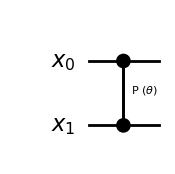

In [161]:
Theta = Parameter(r"$\theta$")

quantum_register = QuantumRegister(2, "x")

quantum_circuit = QuantumCircuit(quantum_register)

quantum_circuit.cp(Theta, quantum_register[0], quantum_register[1])

quantum_circuit.draw(output="mpl", style="bw")